# Модули

In [112]:
import numpy as np
import pandas as pd
from scipy.stats import mannwhitneyu
from scipy.stats import ttest_ind
from scipy.stats import norm
import matplotlib.pyplot as plt
import seaborn as sns

from tqdm.auto import tqdm
import seaborn as sns

plt.style.use('ggplot')
plt.rcParams["figure.figsize"] = (12, 8)

# Функции

In [121]:
def get_bootstrap(
    data_column_1, # числовые значения первой выборки
    data_column_2, # числовые значения второй выборки
    boot_it = 1000, # количество бутстрэп-подвыборок
    statistic = np.mean, # интересующая нас статистика
    bootstrap_conf_level = 0.95 # уровень значимости
):
    """Функция, которая позволит проверять гипотезы с помощью бутстрапа"""
    boot_len = max([len(data_column_1), len(data_column_2)])
    boot_data = []
    for i in tqdm(range(boot_it)): # извлекаем подвыборки
        samples_1 = data_column_1.sample(
            boot_len, 
            replace = True # параметр возвращения
        ).values
        
        samples_2 = data_column_2.sample(
            boot_len, # чтобы сохранить дисперсию, берем такой же размер выборки
            replace = True
        ).values
        
        boot_data.append(statistic(samples_1-samples_2))
    pd_boot_data = pd.DataFrame(boot_data)
        
    left_quant = (1 - bootstrap_conf_level) / 2
    right_quant = 1 - (1 - bootstrap_conf_level) / 2
    quants = pd_boot_data.quantile([left_quant, right_quant])
        
    p_1 = norm.cdf(
        x = 0, 
        loc = np.mean(boot_data), 
        scale = np.std(boot_data)
    )
    p_2 = norm.cdf(
        x = 0, 
        loc = -np.mean(boot_data), 
        scale = np.std(boot_data)
    )
    p_value = min(p_1, p_2) * 2
    print(p_value)
        
    # Визуализация
    _, _, bars = plt.hist(pd_boot_data[0], bins = 50)
    for bar in bars:
        if abs(bar.get_x()) <= quants.iloc[0][0] or abs(bar.get_x()) >= quants.iloc[1][0]:
            bar.set_facecolor('red')
        else: 
            bar.set_facecolor('grey')
            bar.set_edgecolor('black')
    
    plt.style.use('ggplot')
    plt.vlines(quants,ymin=0,ymax=50,linestyle='--')
    plt.text(.96,.94,"p_value: {}".format(p_value), bbox={'facecolor':'w','pad':5},
         ha="right", va="top", transform=plt.gca().transAxes)
    plt.text(.96,.9,"quantiles: {}".format(quants[0].values), bbox={'facecolor':'w','pad':5},
         ha="right", va="top", transform=plt.gca().transAxes)
    
    plt.xlabel('boot_data')
    plt.ylabel('frequency')
    plt.title("Histogram of boot_data")
    plt.show()
       
    return {"boot_data": boot_data, 
            "quants": quants, 
            "p_value": p_value}

# Пример использования Bootstrap

Бутстрап позволяет многократно извлекать подвыборки из выборки, полученной в рамках экспериментва

В полученных подвыборках считаются статистики (среднее, медиана и т.п.)

Из статистик можно получить ее распределение и взять доверительный интервал

ЦПТ, например, не позволяет строить доверительные интервал для медианы, а бутстрэп это может сделать

  0%|          | 0/1000 [00:00<?, ?it/s]

5.220144429344624e-102


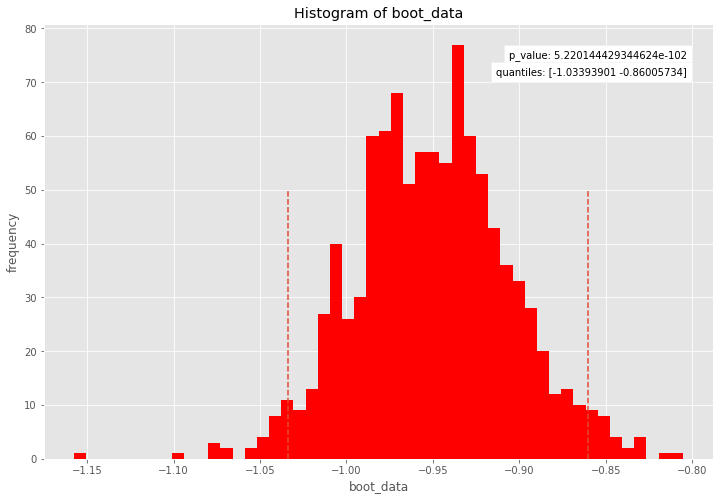

In [125]:
np.random.seed(5)
n = 1000

sample_1 = np.random.normal(0, 1, size=n)
sample_2 = np.random.normal(1, 1, size=n)

df = pd.DataFrame({
    "sample_1": sample_1,
    "sample_2": sample_2
})

booted_data = get_bootstrap(df.sample_1, df.sample_2, boot_it=1000, statistic=np.mean);

# Данные

In [126]:
data_ab = pd.read_csv('data/hw_bootstrap.csv', sep=';', decimal=',')
data_ab.head()

,Unnamed: 0,value,experimentVariant
0,1,9.773113,Treatment
1,2,9.311246,Treatment
2,3,11.172828,Treatment
3,4,11.624510,Treatment
4,5,10.462331,Treatment


# EDA

In [127]:
data_ab.groupby('experimentVariant').agg({'value': ['count', 'mean', 'median']})

value                      
                  count       mean     median
experimentVariant                            
Control             500  10.026867  10.018465
Treatment            50  10.367236  10.420193

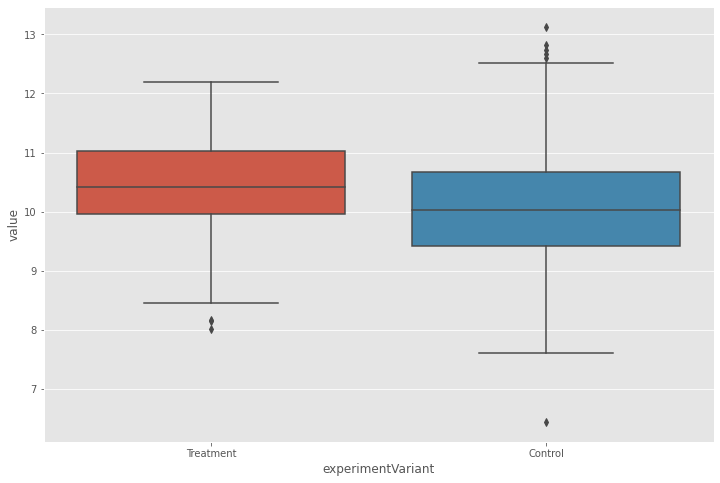

In [128]:
sns.boxplot(x="experimentVariant", y="value", data=data_ab);

No handles with labels found to put in legend.


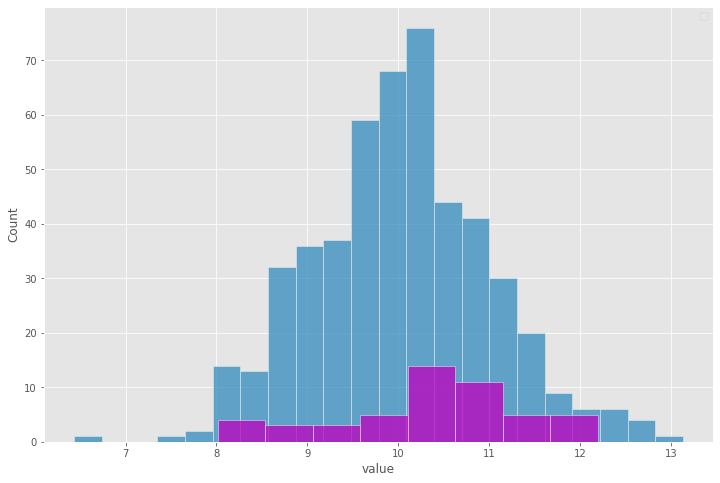

In [129]:
sns.histplot(data_ab[data_ab.experimentVariant == 'Control'].value, kde=False)
sns.histplot(data_ab[data_ab.experimentVariant == 'Treatment'].value, kde=False, color='m')
plt.legend();

# Классичесике тесты

## Mann-Whitney

In [130]:
mannwhitneyu(data_ab[data_ab['experimentVariant'] == 'Treatment'].value, 
             data_ab[data_ab['experimentVariant'] == 'Control'].value)

MannwhitneyuResult(statistic=9508.0, pvalue=0.0026182097937983984)

## T-test

In [131]:
ttest_ind(data_ab[data_ab.experimentVariant == 'Treatment'].value, 
          data_ab[data_ab.experimentVariant == 'Control'].value)

Ttest_indResult(statistic=2.331858965573001, pvalue=0.020069539127355422)

# Bootstrap

  0%|          | 0/1000 [00:00<?, ?it/s]

5.01171213925164e-08


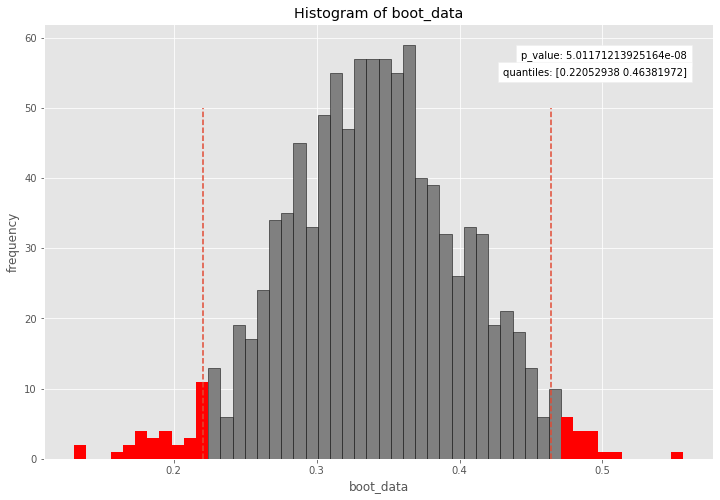

In [132]:
get_bootstrap(
    data_ab[data_ab.experimentVariant == 'Treatment'].value,
    data_ab[data_ab.experimentVariant == 'Control'].value,
    boot_it = 1000,
    statistic = np.mean,
    bootstrap_conf_level = 0.95
);

  0%|          | 0/1000 [00:00<?, ?it/s]

5.43185348516416e-08


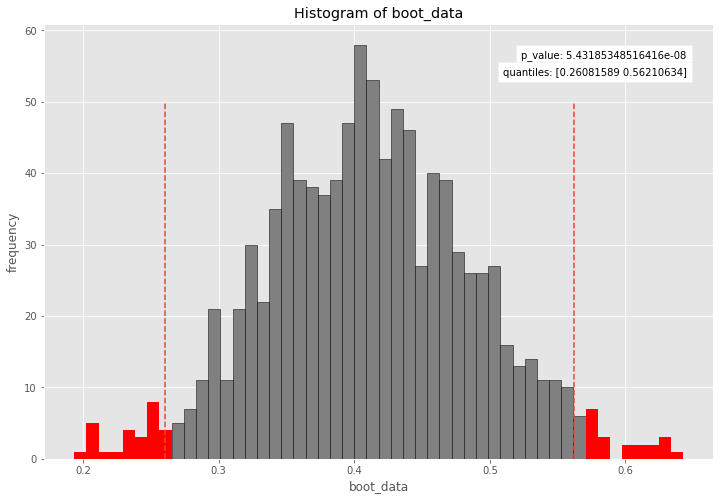

In [133]:
get_bootstrap(
    data_ab[data_ab.experimentVariant == 'Treatment'].value,
    data_ab[data_ab.experimentVariant == 'Control'].value,
    boot_it = 1000,
    statistic = np.median,
    bootstrap_conf_level = 0.95
);